In [1]:
%matplotlib inline
import sys
sys.path.append('/home/paulo/github/bayeseg')

import time
import datetime

import numpy as np
import pandas as pd

from SeqSeg.SeqSeg import SeqSeg

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation

savefolder = '/home/paulo/github/bayeseg/Output/'

# Posteriori para $\bar{t}$ em diversas situações

In [29]:
#Gera dados
N = [5000, 5000, 5000]
s = [1, 2, 1]

y = np.random.normal(scale = s[0], size = N[0])
for i in range(1, len(N)):
    y = np.concatenate([y, np.random.normal(scale = s[i], size = N[i])])

In [30]:
ss = SeqSeg(replicate = False)
ss.feed_data(y)
minlen = 0
p, _ = ss.get_posterior_var(0, len(y), minlen = minlen, res = 1)

In [46]:
fig = plt.figure(figsize = (20, 10))

titfont = {'fontsize' : 32}

plt.plot(p[max(0,minlen-3):(len(y)-minlen-2)], 'black')
plt.grid(True)
plt.rcParams['font.size'] = 26
plt.xlim([0, 15000])
plt.xlabel('Changepoint', **titfont)
plt.ylabel('Log-posterior', **titfont)
plt.savefig('/home/paulo/Documents/Papers/Changepoint/figuras/fig1.pdf', dpi = 1600)
plt.show()

In [26]:
(np.linspace(3, len(y)-3, len(y)-5)).dot(p)

-1990068308116.3816

In [5]:
ss = SeqSeg(replicate = False)
ss.feed_data(y)
minlen = 0
p2, _ = ss.get_posterior_var(0, len(y), minlen = minlen, res = 1)

In [6]:
plt.plot(p2[max(0,minlen-3):(len(y)-minlen-2)])

In [7]:
p[:5]

array([-12946.95288233, -12946.40220553, -12945.66771084, -12944.92680795,
       -12944.25216946])

In [8]:
p2[:5]

array([-12947.65688362, -12947.39528865, -12946.97339464, -12946.46934124,
       -12945.85946059])

## Testing the algorithm on real samples

In [9]:
from OceanPod import OceanPod 


wavfolder = '/home/paulo/github/bayeseg/Data/'
savefolder = '/home/paulo/github/bayeseg/Output/'
filelist = ['2015.01.30_02.02.56.wav', '2015.02.02_07.50.49.wav', '2015.02.08_11.26.39.wav']

# Creates object to read wave files and segments
op = OceanPod(wavfolder)

In [68]:
# MCMC parameters

mciter = 20000
mcburn = 20000
nchains = 1


In [17]:
ss = SeqSeg(replicate = False)

file = filelist[2]

fs, wave = op.readFile(file)
ss.feed_data(wave)

alpha = 0.5819
beta = 3e-9

ss.initialize(beta, alpha, mciter, mcburn, nchains)
tseg, tdur = ss.segments(minlen = 11025, res = 1000, iprior = 1, regularize = False, verbose = False)
print(len(tseg)+1, tdur)

35 1.2982184886932373


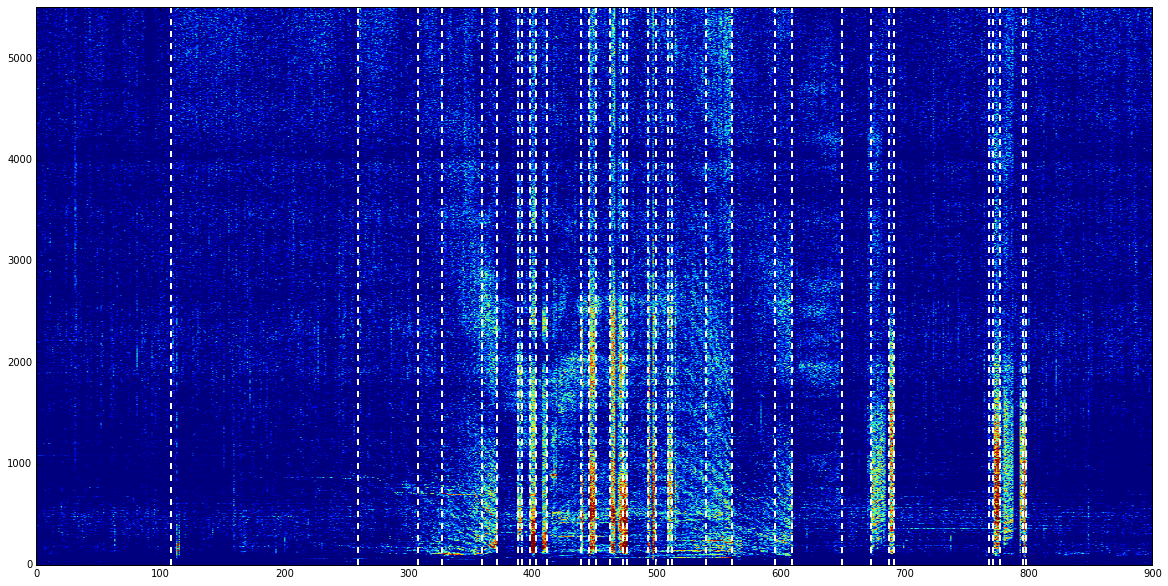

In [18]:
M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

lines = []
for s in tseg:
    lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))

In [6]:
tseg.sort()

tstart = 0
tend = tseg[1]
tcut = tseg[0]

In [7]:
seg = wave[tstart:tend]
fig = plt.figure(figsize = (20, 10))
plt.plot(seg)
plt.vlines(x = tcut, ymin = np.min(seg)*1.2, ymax = np.max(seg)*1.2, linestyles = 'dashed')
plt.ylim([np.min(seg)*1.1, np.max(seg)*1.1])
plt.xlim([tstart, tend])
plt.show()


In [ ]:
import sounddevice as sd

seg = wave[tstart:tend]
plt.plot(seg, '-')
print((tend-tstart)/11025)

sd.play(seg, 11025)

In [ ]:
sd.stop()

In [9]:
ss.feed_data(wave[tstart:tend])
ss.tester(tcut = tcut, iprior = 1)

0.0

# Teste: elicitando a prior para delta

Conclusão: isso não funciona porque na prática o algoritmo não estará comparando segmentos homogêneos. Portanto, dizer que quero rejeitar segmentos de $t$ segundos com $\delta \le d$ não leva em conta que um dos segmentos pode conter um evento menor do que $t$ segundos, seguido por ruído de fundo, o que vai diminuir artificialmente a estimativa de $\delta$

In [54]:
fs = 11025
t = 1
n = t * fs
d = 1.1
y = np.concatenate([np.random.normal(loc = 0.0, scale = 1, size = (n,1)), np.random.normal(loc = 0.0, scale = d, size = (n,1))])
#plt.plot(y)
ss.feed_data(y)

alpha = 0.1
betalist = np.linspace(3e-6, 3e-2, 100)

evs = []
betamax = -1
for beta in betalist:
    ss.initialize(beta, alpha, mciter, mcburn, nchains)
    ev = ss.tester(tcut = n, iprior = 0)
    evs.append(ev)
    if ev == 1:
        if beta > betamax:
            betamax = beta
            

In [55]:
betamax

0.002124

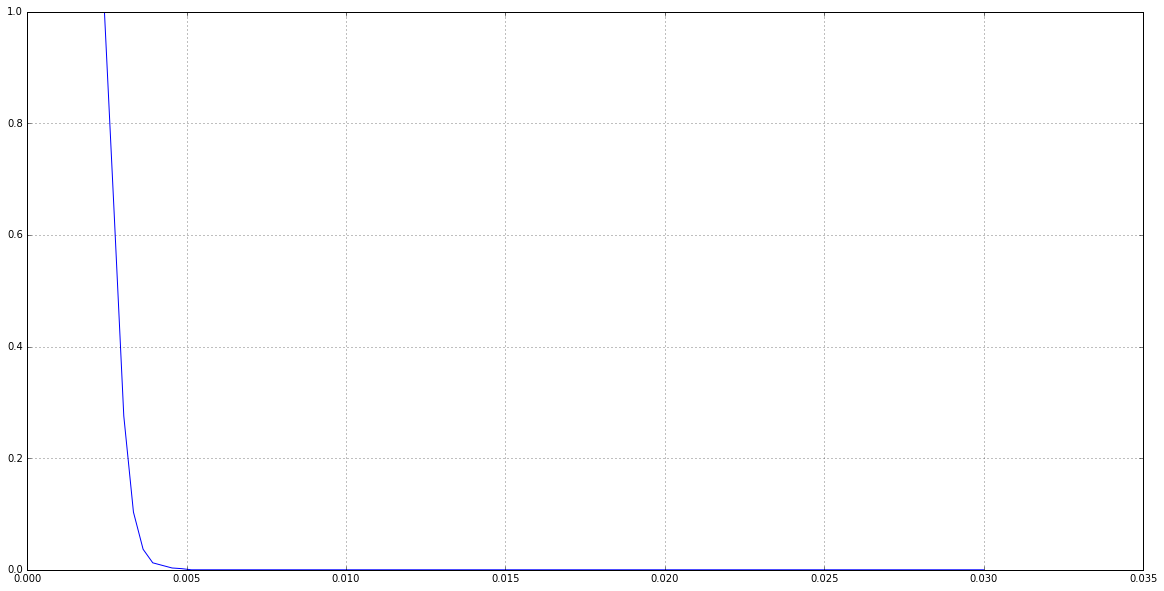

In [56]:
fig = plt.figure(figsize = (20, 10))
plt.plot(betalist, evs)
plt.grid(True)

# Teste 2: calculando uma medida de GOF

AIC e BIC

Observação: a diferença principal entre usar ou não a prior informativa está na **sequência final de segmentos** obtida. Se calculamos a segmentação com prior uniforme e comparamos o BIC, vamos parar num modelo muito ruim com poucos segmentos. Por isso, o legal é calcular a segmentação usando prior de Laplace e variando Beta, e calcular o BIC para cada segmentação.

In [60]:
# Para comparar as segmentações sucessivas
from tqdm import tqdm

# Calculando a segmentação usando prior uniforme
ss.initialize(beta, alpha, mciter, mcburn, nchains)
tseg, tdur = ss.segments(minlen = 11025, res = 1000, iprior = 2, regularize = False, verbose = False)

bics = []
aics = []
for i in tqdm(range(1,len(tseg)+1)):
    tcuts = tseg[:i]
    tcuts.sort()
    loglik = 0
    for j in range(len(tcuts)):
        if j == 0:
            s = np.var(wave[:tcuts[j]])
            loglik = loglik - (tcuts[j]/2)*np.log(s) - np.sum(wave[:tcuts[j]]**2)/(2*s)
        elif j < len(tcuts)-1:
            s = np.var(wave[tcuts[j-1]:tcuts[j]])
            loglik = loglik - ((tcuts[j]-tcuts[j-1]+1)/2)*np.log(s) - np.sum(wave[tcuts[j-1]:tcuts[j]]**2)/(2*s)
        else:
            s = np.var(wave[tcuts[j]:])
            loglik = loglik - ((len(wave)-tcuts[j])/2)*np.log(s) - np.sum(wave[tcuts[j]:]**2)/(2*s)
    bic = np.log(len(wave))*(2*len(tcuts)+1) - 2*loglik
    aic = 2*(2*len(tcuts)+1) - 2*loglik
    bics.append(bic)
    aics.append(aic)
    

100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


In [87]:
betalist = np.linspace(3e-6, 3e-4, 10000)

tsegs = []
for i in tqdm(range(len(betalist))):
    beta = betalist[i]
    ss.initialize(beta, alpha, mciter, mcburn, nchains)
    tseg, tdur = ss.segments(minlen = 11025, res = 1000, iprior = 0, regularize = False, verbose = False)
    #print("beta = {:.4}, nsegs = {}".format(beta, len(tseg)+1))
    tsegs.append(tseg)           

  1%|▏         | 147/10000 [01:14<1:23:29,  1.97it/s]

Adaptive covariance defective!


  3%|▎         | 255/10000 [02:27<1:33:52,  1.73it/s]

Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!


  3%|▎         | 263/10000 [02:32<1:34:20,  1.72it/s]

Posterior variance of signal power with negative value!


  4%|▍         | 421/10000 [04:31<1:43:04,  1.55it/s]

Posterior variance of signal power with negative value!


  5%|▍         | 467/10000 [05:08<1:44:56,  1.51it/s]

Posterior variance of delta with negative value!


  6%|▌         | 550/10000 [06:15<1:47:23,  1.47it/s]

Posterior variance of signal power with negative value!


  9%|▉         | 940/10000 [12:42<2:02:30,  1.23it/s]

Posterior variance of delta with negative value!


 11%|█         | 1105/10000 [15:50<2:07:33,  1.16it/s]

Posterior variance of signal power with negative value!


 13%|█▎        | 1268/10000 [19:08<2:11:49,  1.10it/s]

Posterior variance of signal power with negative value!


 13%|█▎        | 1291/10000 [19:37<2:12:20,  1.10it/s]

Posterior variance of signal power with negative value!


 13%|█▎        | 1302/10000 [19:50<2:12:35,  1.09it/s]

Posterior variance of signal power with negative value!


 15%|█▍        | 1452/10000 [22:56<2:15:04,  1.05it/s]

Posterior variance of signal power with negative value!


 15%|█▌        | 1535/10000 [24:47<2:16:43,  1.03it/s]

Posterior variance of delta with negative value!


 16%|█▌        | 1551/10000 [25:08<2:16:59,  1.03it/s]

Posterior variance of signal power with negative value!


 16%|█▌        | 1610/10000 [26:27<2:17:55,  1.01it/s]

Posterior variance of delta with negative value!


 16%|█▋        | 1648/10000 [27:19<2:18:26,  1.01it/s]

Posterior variance of signal power with negative value!


 18%|█▊        | 1769/10000 [30:03<2:19:50,  1.02s/it]

Posterior variance of delta with negative value!


 18%|█▊        | 1787/10000 [30:27<2:20:00,  1.02s/it]

Posterior variance of delta with negative value!


 18%|█▊        | 1804/10000 [30:53<2:20:18,  1.03s/it]

Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!


 19%|█▉        | 1879/10000 [32:35<2:20:51,  1.04s/it]

Posterior variance of signal power with negative value!


 19%|█▉        | 1905/10000 [33:10<2:20:59,  1.05s/it]

Posterior variance of signal power with negative value!


 19%|█▉        | 1907/10000 [33:13<2:21:00,  1.05s/it]

Posterior variance of delta with negative value!


 20%|█▉        | 1976/10000 [34:47<2:21:16,  1.06s/it]

Posterior variance of delta with negative value!


 20%|██        | 2016/10000 [35:41<2:21:21,  1.06s/it]

Posterior variance of signal power with negative value!


 21%|██        | 2074/10000 [37:00<2:21:25,  1.07s/it]

Posterior variance of signal power with negative value!


 21%|██        | 2097/10000 [37:31<2:21:25,  1.07s/it]

Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!


 22%|██▏       | 2203/10000 [39:58<2:21:29,  1.09s/it]

Adaptive covariance defective!


 23%|██▎       | 2265/10000 [41:25<2:21:26,  1.10s/it]

Posterior variance of signal power with negative value!


 24%|██▍       | 2389/10000 [44:28<2:21:41,  1.12s/it]

Adaptive covariance defective!


 26%|██▌       | 2572/10000 [49:13<2:22:10,  1.15s/it]

Posterior variance of signal power with negative value!


 26%|██▌       | 2597/10000 [49:54<2:22:17,  1.15s/it]

Posterior variance of signal power with negative value!


 26%|██▋       | 2628/10000 [50:42<2:22:14,  1.16s/it]

Posterior variance of signal power with negative value!


 27%|██▋       | 2670/10000 [51:50<2:22:18,  1.16s/it]

Posterior variance of delta with negative value!


 28%|██▊       | 2777/10000 [54:38<2:22:08,  1.18s/it]

Posterior variance of signal power with negative value!


 28%|██▊       | 2792/10000 [55:02<2:22:05,  1.18s/it]

Posterior variance of signal power with negative value!


 28%|██▊       | 2803/10000 [55:19<2:22:03,  1.18s/it]

Posterior variance of delta with negative value!


 30%|██▉       | 2950/10000 [59:17<2:21:40,  1.21s/it]

Posterior variance of signal power with negative value!


 31%|███       | 3058/10000 [1:02:11<2:21:11,  1.22s/it]

Posterior variance of delta with negative value!


 32%|███▏      | 3160/10000 [1:04:55<2:20:32,  1.23s/it]

Posterior variance of signal power with negative value!


 33%|███▎      | 3340/10000 [1:09:52<2:19:20,  1.26s/it]

Posterior variance of signal power with negative value!


 35%|███▍      | 3475/10000 [1:13:39<2:18:18,  1.27s/it]

Posterior variance of delta with negative value!


 35%|███▌      | 3517/10000 [1:14:49<2:17:55,  1.28s/it]

Posterior variance of signal power with negative value!


 37%|███▋      | 3728/10000 [1:20:46<2:15:53,  1.30s/it]

Posterior variance of signal power with negative value!


 38%|███▊      | 3791/10000 [1:22:32<2:15:11,  1.31s/it]

Posterior variance of signal power with negative value!


 39%|███▊      | 3861/10000 [1:24:30<2:14:22,  1.31s/it]

Posterior variance of delta with negative value!


 39%|███▉      | 3935/10000 [1:26:35<2:13:28,  1.32s/it]

Posterior variance of signal power with negative value!


 40%|████      | 4029/10000 [1:29:17<2:12:19,  1.33s/it]

Posterior variance of signal power with negative value!


 42%|████▏     | 4152/10000 [1:32:48<2:10:43,  1.34s/it]

Posterior variance of delta with negative value!


 42%|████▏     | 4155/10000 [1:32:53<2:10:40,  1.34s/it]

Posterior variance of delta with negative value!


 43%|████▎     | 4278/10000 [1:36:23<2:08:55,  1.35s/it]

Posterior variance of signal power with negative value!


 43%|████▎     | 4305/10000 [1:37:09<2:08:32,  1.35s/it]

Posterior variance of signal power with negative value!


 44%|████▍     | 4378/10000 [1:39:18<2:07:31,  1.36s/it]

Posterior variance of delta with negative value!


 44%|████▍     | 4393/10000 [1:39:44<2:07:17,  1.36s/it]

Posterior variance of delta with negative value!


 44%|████▍     | 4429/10000 [1:40:46<2:06:45,  1.37s/it]

Posterior variance of delta with negative value!


 45%|████▍     | 4485/10000 [1:42:24<2:05:55,  1.37s/it]

Posterior variance of signal power with negative value!


 46%|████▌     | 4571/10000 [1:44:54<2:04:36,  1.38s/it]

Posterior variance of delta with negative value!


 46%|████▌     | 4575/10000 [1:45:01<2:04:32,  1.38s/it]

Posterior variance of delta with negative value!
Posterior variance of delta with negative value!


 47%|████▋     | 4672/10000 [1:47:52<2:03:01,  1.39s/it]

Posterior variance of signal power with negative value!


 49%|████▉     | 4894/10000 [1:54:28<1:59:26,  1.40s/it]

Posterior variance of signal power with negative value!


 51%|█████▏    | 5135/10000 [2:01:39<1:55:15,  1.42s/it]

Posterior variance of signal power with negative value!


 52%|█████▏    | 5194/10000 [2:03:24<1:54:11,  1.43s/it]

Posterior variance of delta with negative value!


 52%|█████▏    | 5239/10000 [2:04:48<1:53:25,  1.43s/it]

Posterior variance of signal power with negative value!


 52%|█████▎    | 5250/10000 [2:05:09<1:53:13,  1.43s/it]

Adaptive covariance defective!


 54%|█████▍    | 5390/10000 [2:09:33<1:50:48,  1.44s/it]

Posterior variance of signal power with negative value!


 55%|█████▍    | 5465/10000 [2:12:00<1:49:33,  1.45s/it]

Posterior variance of delta with negative value!


 55%|█████▌    | 5515/10000 [2:13:37<1:48:40,  1.45s/it]

Posterior variance of signal power with negative value!


 56%|█████▌    | 5614/10000 [2:16:52<1:46:56,  1.46s/it]

Posterior variance of signal power with negative value!


 57%|█████▋    | 5679/10000 [2:19:03<1:45:48,  1.47s/it]

Posterior variance of signal power with negative value!


 58%|█████▊    | 5834/10000 [2:24:14<1:43:00,  1.48s/it]

Posterior variance of signal power with negative value!


 59%|█████▉    | 5916/10000 [2:26:59<1:41:28,  1.49s/it]

Posterior variance of signal power with negative value!


 60%|█████▉    | 5973/10000 [2:28:54<1:40:23,  1.50s/it]

Posterior variance of signal power with negative value!


 61%|██████    | 6078/10000 [2:32:34<1:38:27,  1.51s/it]

Posterior variance of delta with negative value!
Posterior variance of signal power with negative value!


 61%|██████    | 6122/10000 [2:34:04<1:37:36,  1.51s/it]

Posterior variance of signal power with negative value!


 62%|██████▏   | 6159/10000 [2:35:20<1:36:52,  1.51s/it]

Posterior variance of signal power with negative value!


 63%|██████▎   | 6296/10000 [2:40:02<1:34:09,  1.53s/it]

Posterior variance of signal power with negative value!


 64%|██████▍   | 6378/10000 [2:42:51<1:32:28,  1.53s/it]

Posterior variance of signal power with negative value!


 64%|██████▍   | 6402/10000 [2:43:40<1:31:58,  1.53s/it]

Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!
Adaptive covariance defective!


 65%|██████▌   | 6537/10000 [2:48:20<1:29:10,  1.55s/it]

Posterior variance of signal power with negative value!


 66%|██████▌   | 6576/10000 [2:49:44<1:28:22,  1.55s/it]

Posterior variance of signal power with negative value!


 67%|██████▋   | 6669/10000 [2:53:02<1:26:25,  1.56s/it]

Adaptive covariance defective!


 67%|██████▋   | 6674/10000 [2:53:12<1:26:19,  1.56s/it]

Posterior variance of delta with negative value!


 67%|██████▋   | 6711/10000 [2:54:31<1:25:31,  1.56s/it]

Posterior variance of delta with negative value!


 67%|██████▋   | 6748/10000 [2:55:48<1:24:43,  1.56s/it]

Posterior variance of signal power with negative value!


 68%|██████▊   | 6801/10000 [2:57:39<1:23:34,  1.57s/it]

Posterior variance of signal power with negative value!


 68%|██████▊   | 6811/10000 [2:58:01<1:23:21,  1.57s/it]

Posterior variance of signal power with negative value!


 69%|██████▉   | 6913/10000 [3:01:37<1:21:06,  1.58s/it]

Posterior variance of delta with negative value!


 70%|██████▉   | 6982/10000 [3:04:02<1:19:33,  1.58s/it]

Posterior variance of signal power with negative value!


 70%|███████   | 7022/10000 [3:05:26<1:18:38,  1.58s/it]

Posterior variance of signal power with negative value!


 71%|███████   | 7053/10000 [3:06:31<1:17:56,  1.59s/it]

Posterior variance of signal power with negative value!


 72%|███████▏  | 7179/10000 [3:10:59<1:15:03,  1.60s/it]

Posterior variance of signal power with negative value!


 75%|███████▍  | 7454/10000 [3:20:48<1:08:35,  1.62s/it]

Posterior variance of delta with negative value!


 75%|███████▍  | 7464/10000 [3:21:10<1:08:21,  1.62s/it]

Posterior variance of signal power with negative value!


 76%|███████▌  | 7561/10000 [3:24:37<1:06:00,  1.62s/it]

Posterior variance of signal power with negative value!


 76%|███████▌  | 7584/10000 [3:25:26<1:05:26,  1.63s/it]

Posterior variance of signal power with negative value!


 76%|███████▌  | 7589/10000 [3:25:37<1:05:19,  1.63s/it]

Posterior variance of delta with negative value!


 77%|███████▋  | 7732/10000 [3:30:44<1:01:49,  1.64s/it]

Posterior variance of signal power with negative value!


 77%|███████▋  | 7744/10000 [3:31:12<1:01:31,  1.64s/it]

Posterior variance of signal power with negative value!


 78%|███████▊  | 7803/10000 [3:33:18<1:00:03,  1.64s/it]

Posterior variance of signal power with negative value!


 79%|███████▉  | 7940/10000 [3:38:11<56:36,  1.65s/it]  

Posterior variance of delta with negative value!


 80%|███████▉  | 7951/10000 [3:38:34<56:19,  1.65s/it]

Posterior variance of signal power with negative value!


 80%|███████▉  | 7972/10000 [3:39:21<55:48,  1.65s/it]

Posterior variance of delta with negative value!


 80%|████████  | 8048/10000 [3:42:03<53:51,  1.66s/it]

Posterior variance of delta with negative value!


 82%|████████▏ | 8202/10000 [3:47:32<49:52,  1.66s/it]

Posterior variance of signal power with negative value!


 83%|████████▎ | 8336/10000 [3:52:22<46:23,  1.67s/it]

ZeroDivisionError: float division

Exception ignored in: 'SeqSeg.SeqSeg.cmcmc'
ZeroDivisionError: float division
 84%|████████▍ | 8424/10000 [3:55:33<44:04,  1.68s/it]

Posterior variance of signal power with negative value!


 85%|████████▍ | 8496/10000 [3:58:11<42:09,  1.68s/it]

Posterior variance of signal power with negative value!


 88%|████████▊ | 8792/10000 [4:09:08<34:13,  1.70s/it]

Posterior variance of signal power with negative value!


 90%|████████▉ | 8955/10000 [4:15:10<29:46,  1.71s/it]

Posterior variance of signal power with negative value!


 90%|█████████ | 9032/10000 [4:17:58<27:38,  1.71s/it]

Posterior variance of signal power with negative value!


 92%|█████████▏| 9193/10000 [4:23:53<23:09,  1.72s/it]

Posterior variance of delta with negative value!


 92%|█████████▏| 9204/10000 [4:24:17<22:51,  1.72s/it]

Posterior variance of signal power with negative value!


 93%|█████████▎| 9257/10000 [4:26:13<21:22,  1.73s/it]

Posterior variance of signal power with negative value!


 96%|█████████▌| 9567/10000 [4:38:03<12:35,  1.74s/it]

Posterior variance of signal power with negative value!


 96%|█████████▌| 9615/10000 [4:39:54<11:12,  1.75s/it]

Posterior variance of delta with negative value!


 97%|█████████▋| 9732/10000 [4:44:25<07:49,  1.75s/it]

Posterior variance of signal power with negative value!


 98%|█████████▊| 9752/10000 [4:45:11<07:15,  1.75s/it]

Posterior variance of signal power with negative value!


 98%|█████████▊| 9768/10000 [4:45:49<06:47,  1.76s/it]

Posterior variance of signal power with negative value!


 98%|█████████▊| 9769/10000 [4:45:51<06:45,  1.76s/it]

Posterior variance of signal power with negative value!


 99%|█████████▊| 9865/10000 [4:49:39<03:57,  1.76s/it]

Posterior variance of signal power with negative value!


 99%|█████████▊| 9872/10000 [4:49:56<03:45,  1.76s/it]

Posterior variance of signal power with negative value!


100%|█████████▉| 9972/10000 [4:53:55<00:49,  1.77s/it]

Posterior variance of delta with negative value!


100%|██████████| 10000/10000 [4:55:01<00:00,  1.77s/it]


In [88]:
# Para comparar diferentes segmentações com diferentes betas
from tqdm import tqdm

bics = []
aics = []
for i in tqdm(range(len(tsegs))):
    tcuts = tsegs[i]
    tcuts.sort()
    loglik = 0
    for j in range(len(tcuts)):
        if j == 0:
            s = np.var(wave[:tcuts[j]])
            loglik = loglik - (tcuts[j]/2)*np.log(s) - np.sum(wave[:tcuts[j]]**2)/(2*s)
        elif j < len(tcuts)-1:
            s = np.var(wave[tcuts[j-1]:tcuts[j]])
            loglik = loglik - ((tcuts[j]-tcuts[j-1]+1)/2)*np.log(s) - np.sum(wave[tcuts[j-1]:tcuts[j]]**2)/(2*s)
        else:
            s = np.var(wave[tcuts[j]:])
            loglik = loglik - ((len(wave)-tcuts[j])/2)*np.log(s) - np.sum(wave[tcuts[j]:]**2)/(2*s)
    bic = np.log(len(wave))*(2*len(tcuts)+1) - 2*loglik
    aic = 2*(2*len(tcuts)+1) - 2*loglik
    bics.append(bic)
    aics.append(aic)

100%|██████████| 10000/10000 [10:06<00:00, 16.47it/s]


In [106]:
import pickle

with open('bics.pkl', 'wb') as arq:
    pickle.dump(bics, arq)

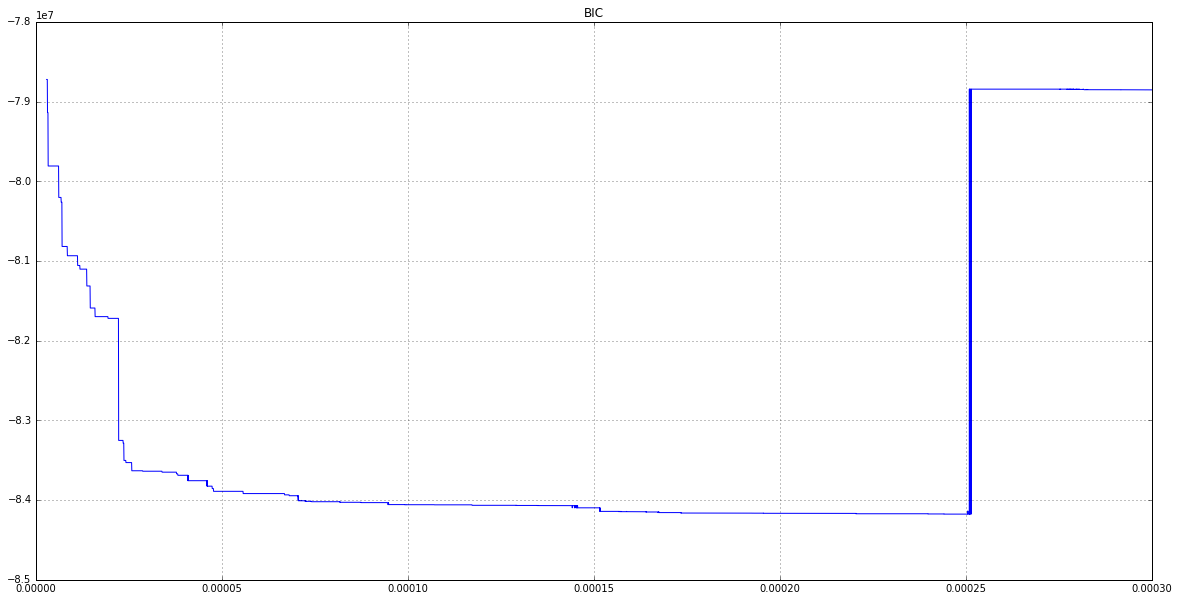

In [118]:
fig = plt.figure(figsize = (20, 10))
plt.plot(betalist, bics)
plt.grid(True)
plt.title("BIC")
plt.show()

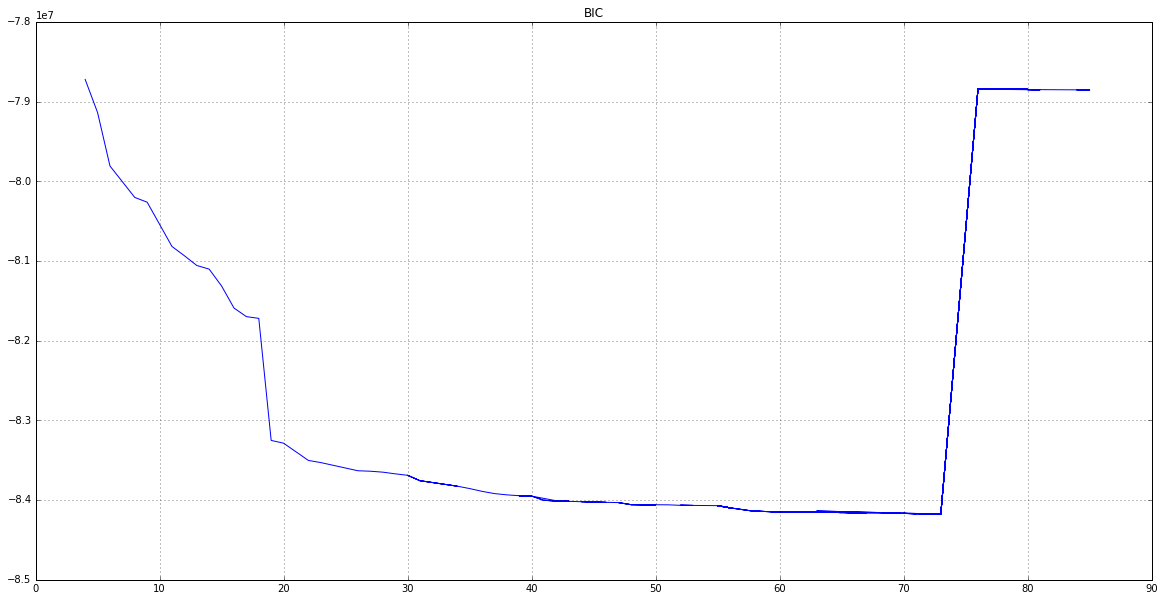

In [119]:
nsegs = [len(t) for t in tsegs]

fig = plt.figure(figsize = (20, 10))
plt.plot(nsegs, bics)
plt.grid(True)
plt.title("BIC")
plt.show()

In [122]:
dfbic = pd.DataFrame({'beta' : betalist, 'nseg' : nsegs, 'bic' : bics})
dfbic = dfbic.groupby('bic').agg({'beta' : 'max', 'nseg' : 'max'}).reset_index()
dfbic = dfbic.sort_values('nseg')

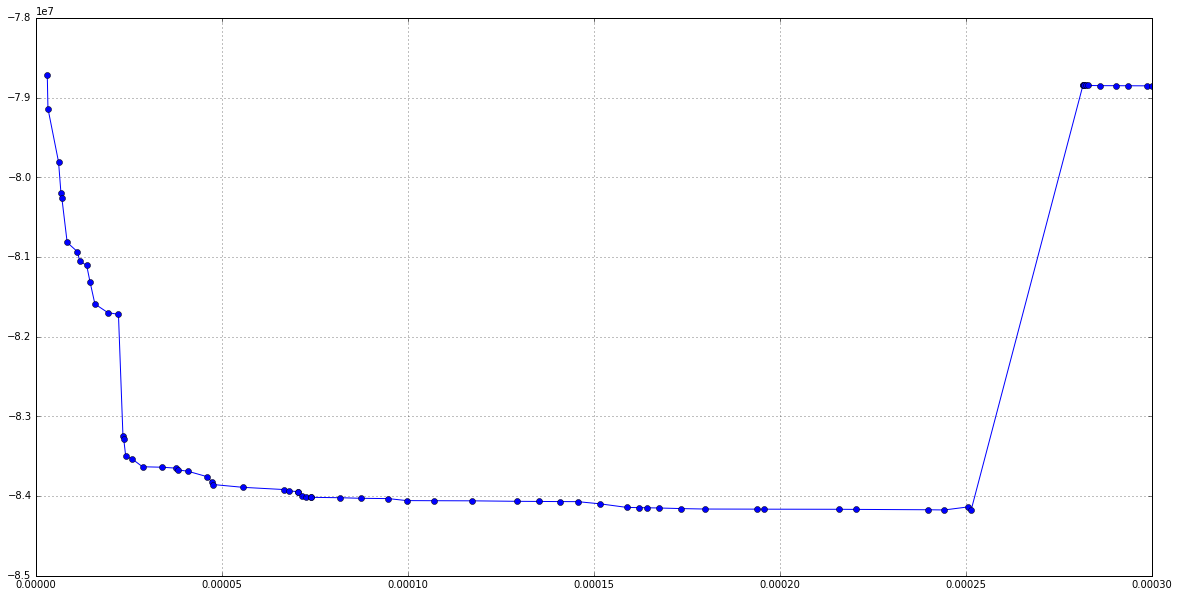

In [185]:
dfbic = dfbic.sort_values('beta')
fig = plt.figure(figsize = (20, 10))
plt.plot(dfbic.beta, dfbic.bic, 'o-')
plt.grid(True)
plt.show()

In [132]:
topt = tsegs[np.argmin(bics)-1]

In [133]:
# Número ótimo de segmentos e beta ótimo
nopt = len(topt) + 1
betaopt = betalist[np.argmin(bics)]

In [134]:
betaopt

0.00024409900990099003

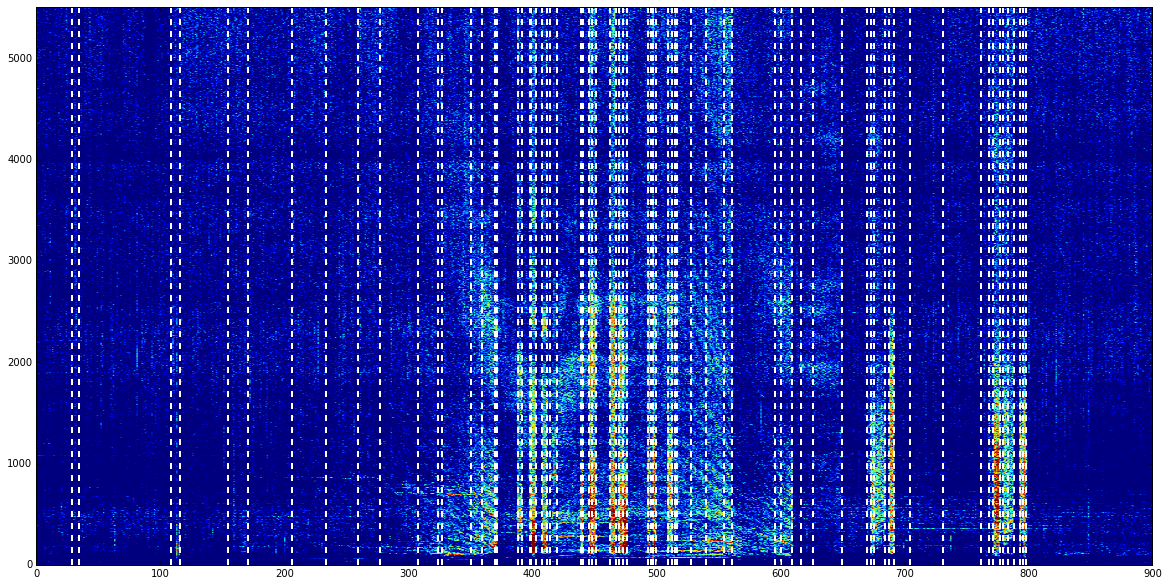

In [92]:
M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

lines = []
for s in topt:
    lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))

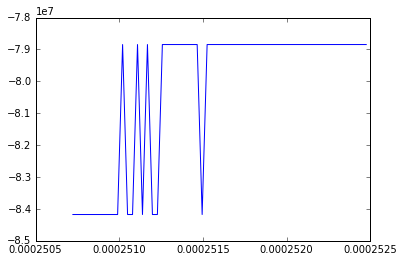

In [104]:
# O que acontece perto de Beta = 0.00025?
plt.plot(betalist[8340:8400], bics[8340:8400])

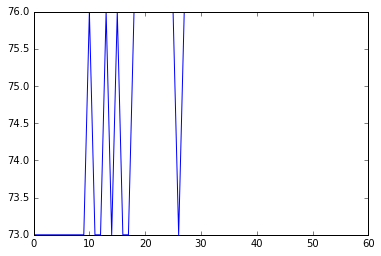

In [105]:
plt.plot(nsegs[8340:8400])

In [112]:
ttest = tsegs[8340]

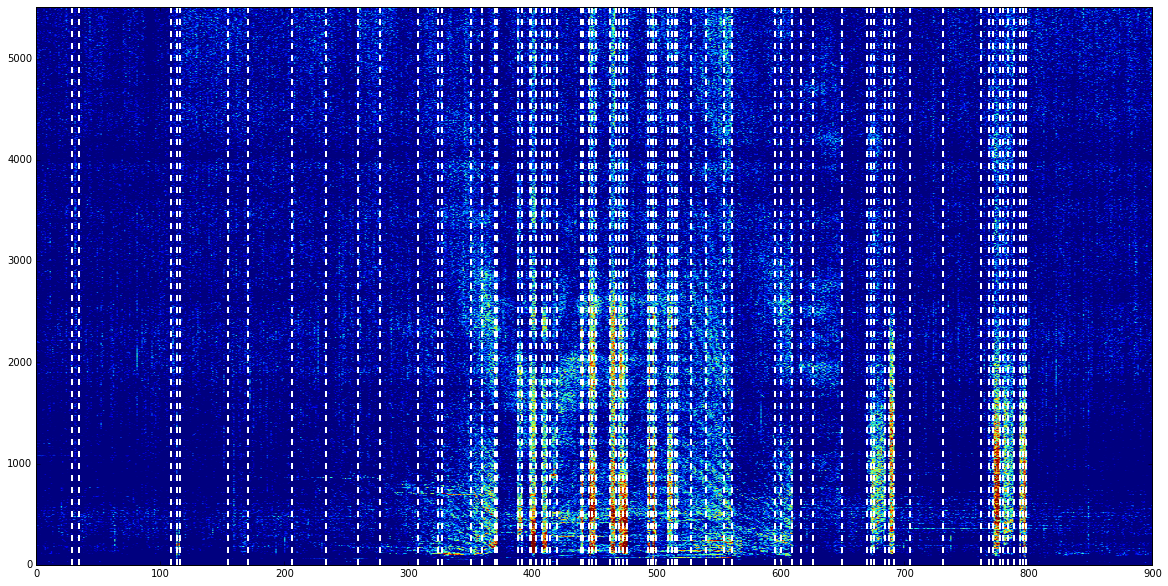

In [113]:
M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

lines = []
for s in ttest:
    lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))

In [110]:
ttest = tsegs[8399]

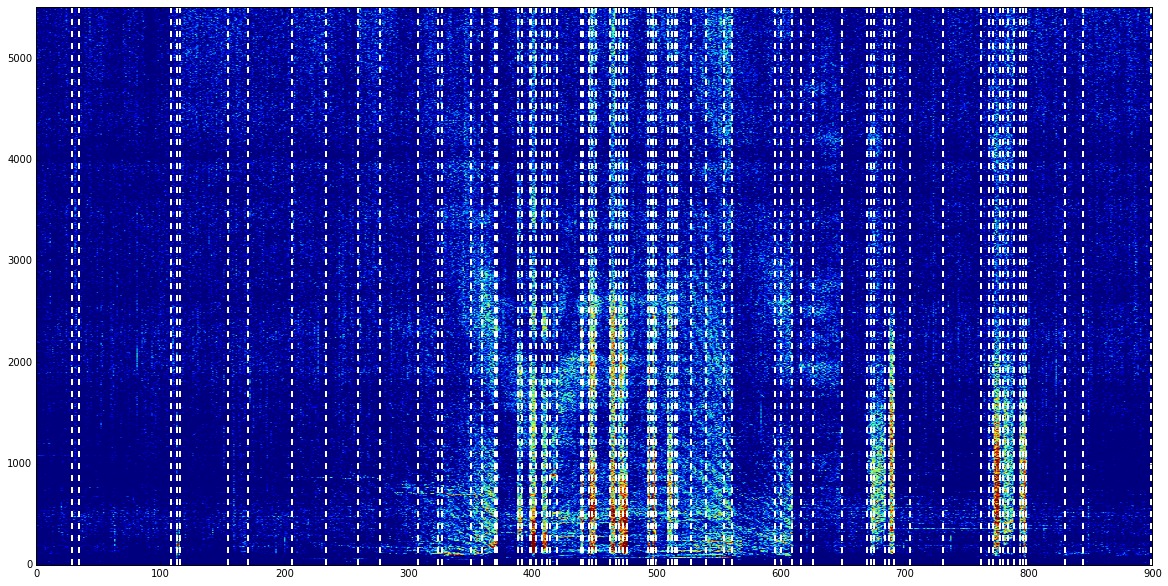

In [111]:
M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

lines = []
for s in ttest:
    lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))

In [114]:
ttest1 = tsegs[8340]
ttest2 = tsegs[8399]

In [116]:
new_segs = [t for t in ttest2 if t not in ttest1]

In [117]:
new_segs

[9147015, 9309019, 9909015]

In [174]:
# Escutando alguns segmentos 
topt.sort()

# Escolhendo o trecho 
t0 = 300
t1 = 380
fs = 11025
seg = wave[t0*fs:t1*fs]

# Segmentos do trecho
segs = [t for t in topt if t >= t0*fs and t <= t1*fs]

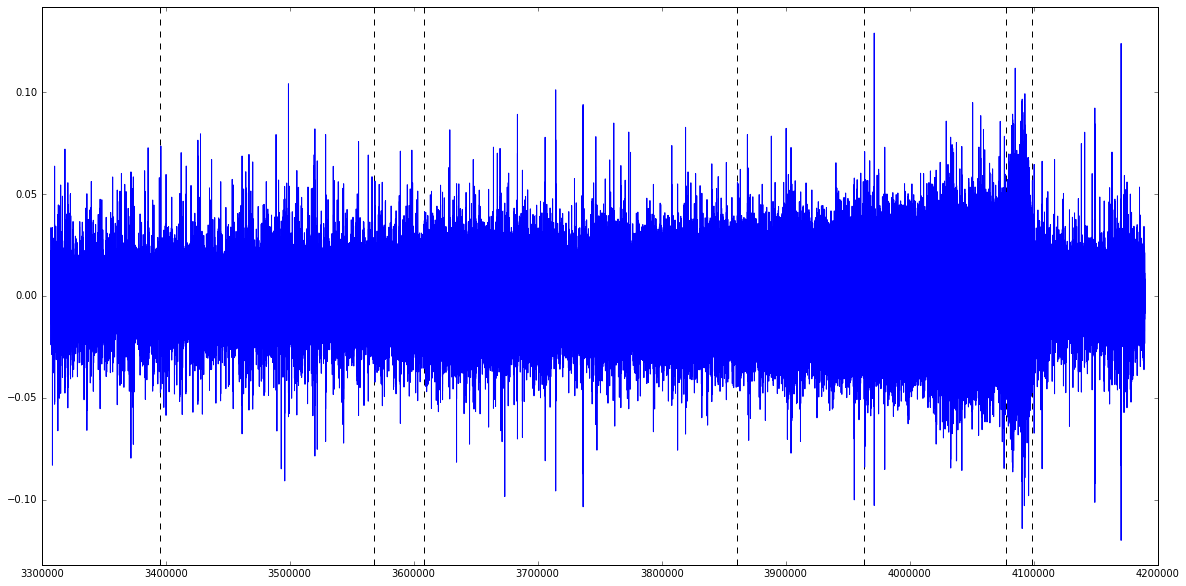

In [175]:
import sounddevice as sd
import time

fig = plt.figure(figsize = (20, 10))
plt.plot(np.linspace(t0*fs, t1*fs, len(seg)), seg, '-')
for s in segs:
    plt.vlines(x = s, ymin = np.min(seg)*1.2, ymax = np.max(seg)*1.2, linestyles = 'dashed')
    
plt.ylim(np.min(seg)*1.1, np.max(seg)*1.1)
plt.show()

In [184]:
for i in range(len(segs)+1):
    if i == 0:
        i0 = t0*fs
        i1 = segs[i]
    elif i == len(segs):
        i0 = segs[i-1]
        i1 = t1*fs
    else:
        i0 = segs[i-1]
        i1 = segs[i]
    
    print("Segmento {} com duração de {:.3} segundos".format(i+1, (i1-i0)/fs))
    seg = wave[i0:i1]
    sd.play(seg, 11025)
    time.sleep((i1-i0)/fs + 1)
    sd.stop()

Segmento 1 com duração de 7.94 segundos
Segmento 2 com duração de 15.7 segundos
Segmento 3 com duração de 3.63 segundos
Segmento 4 com duração de 22.9 segundos
Segmento 5 com duração de 9.25 segundos
Segmento 6 com duração de 10.4 segundos
Segmento 7 com duração de 1.9 segundos
Segmento 8 com duração de 8.21 segundos


In [181]:
sd.stop()

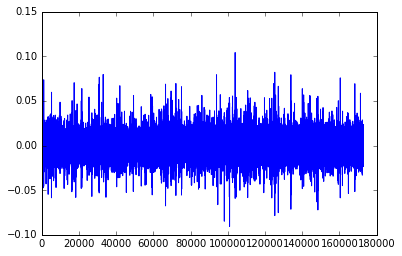

In [145]:
i = 0
seg = wave[segs[i]:segs[i+1]]
plt.plot(seg)
sd.play(seg, fs)

# Comparando modelos

Com $n$ versus $n+1$ pontos de corte.

Em vez de testar a igualdade de variâncias, comparar os modelos usando o FBST.



# Posterior de t

In [9]:
filelist

['2015.01.30_02.02.56.wav',
 '2015.02.02_07.50.49.wav',
 '2015.02.08_11.26.39.wav']

In [10]:
# Obtaining the posterior on \bar{t}
file = filelist[0]

ss = SeqSeg(replicate = False)

fs, wave = op.readFile(file)
ss.feed_data(wave)

post, t = ss.get_posterior(0, len(wave), res = 1)

wwidth = 11025*10
s = int(len(wave) / wwidth-1)
apost = np.zeros(shape = (s,))

for i in range(s):
    apost[i] = np.sum(post[i*wwidth:(i+1)*wwidth])

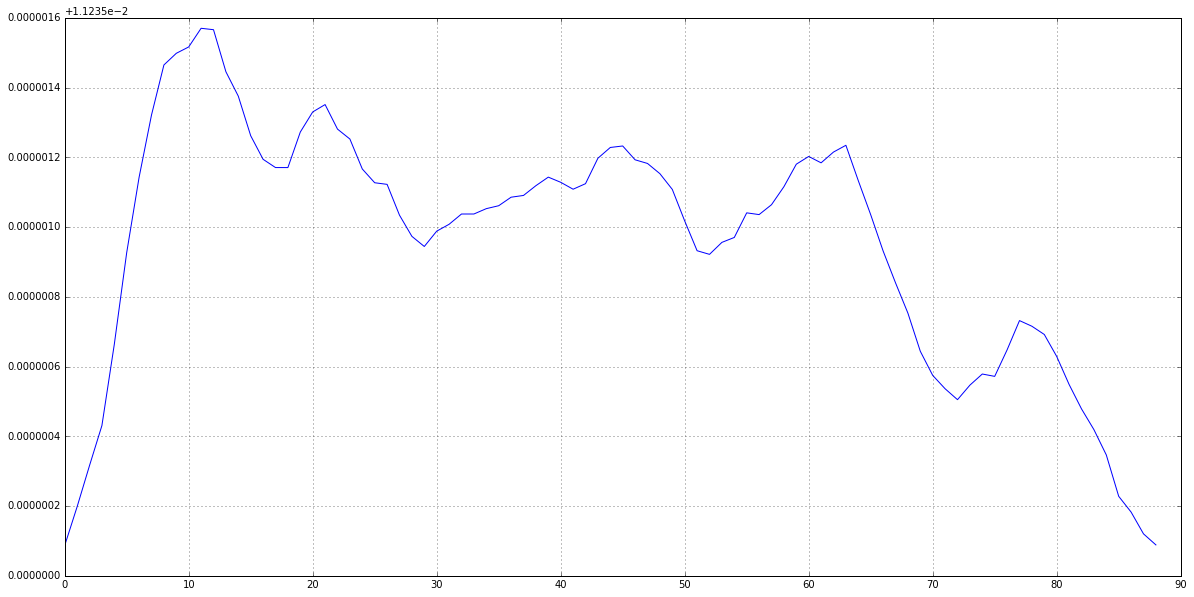

In [11]:
fig = plt.figure(figsize = (20, 10))
plt.plot(apost/np.sum(apost))
plt.grid(True)
#plt.savefig('/home/paulo/Documents/Apresentações/Post_08022015.png')
plt.show()

In [12]:
# Obtaining the posterior on \bar{t}
file = filelist[0]

ss = SeqSeg(replicate = False)

fs, wave = op.readFile(file)
ss.feed_data(wave)

post, t = ss.get_posterior_var(0, len(wave), res = 1)

wwidth = 11025*10
s = int(len(wave) / wwidth-1)
apost = np.zeros(shape = (s,))

for i in range(s):
    apost[i] = np.sum(post[i*wwidth:(i+1)*wwidth])

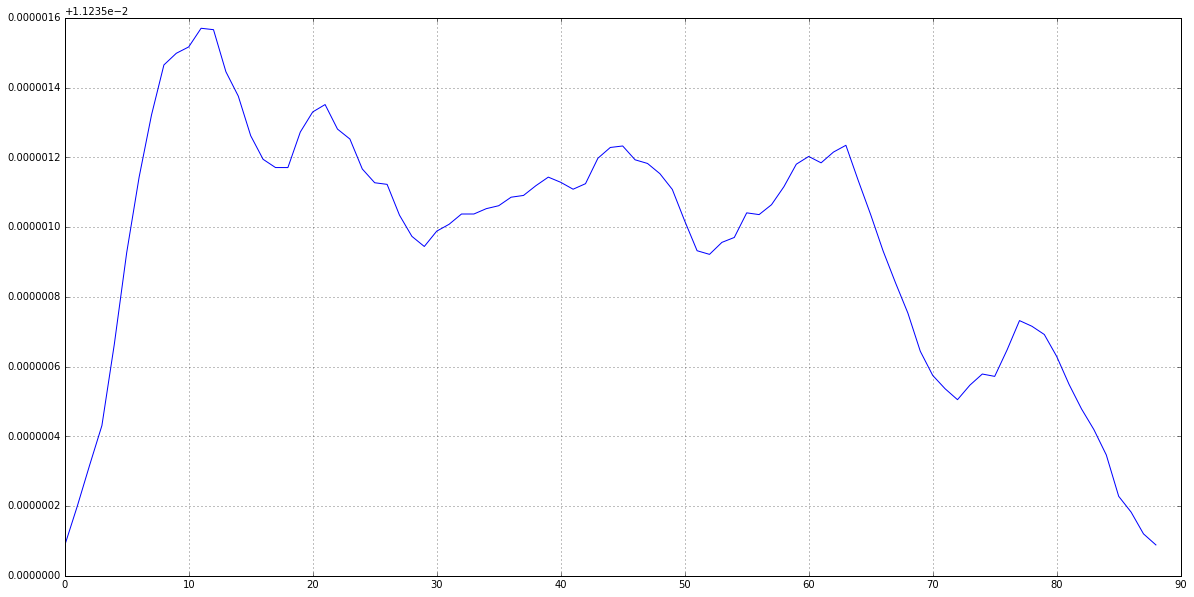

In [13]:
fig = plt.figure(figsize = (20, 10))
plt.plot(apost/np.sum(apost))
plt.grid(True)
#plt.savefig('/home/paulo/Documents/Apresentações/Post_08022015.png')
plt.show()

# Número de segmentos variando beta

In [ ]:
ss = SeqSeg(replicate = False)

file = filelist[2]

fs, wave = op.readFile(file)
ss.feed_data(wave)

alpha = 0.1
betalist = np.linspace(start = 5e-6, stop = 5e-5, num = 100)

results = []
for beta in betalist:
    ss.initialize(beta, alpha, mciter, mcburn, nchains)
    tseg, tdur = ss.segments(minlen = 11025, res = 11025, iprior = 0, verbose = False)
    nseg = len(tseg) + 1
    results.append((beta,tseg))
    print(beta, nseg)



# Criando gifs

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation

def update(i):
    tseg = results[i][1]
    if i > 0:
        tsegult = results[i-1][1]
    else:
        tsegult = []
    lines = []
    for s in tseg:
        if s not in tsegult:
            lines.append(ax.axvline(x = s/11025, linestyle = '--', color = 'white', linewidth = 2))
    msg = "Beta = {:.2}, N = {}".format(results[i][0], len(tseg) + 1)
    ax.set_xlabel(msg, fontsize = 22)
    return ax, lines

M = 11025
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.jet, xextent=None, pad_to=None, sides='default',
         scale_by_freq=None, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Frequency (Hz)', fontsize = 22)
plt.rcParams.update({'font.size' : 22})

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, len(results)), interval=500)

anim.save('/home/paulo/Desktop/spec_lines_part1.gif', dpi=80, writer='imagemagick')

# plt.show() will just loop the animation forever.
plt.show()


# Criando espectrograma com prior de t 

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors

file = filelist[0]

ss = SeqSeg(replicate = False)

fs, wave = op.readFile(file)
ss.feed_data(wave)

post, t = ss.get_posterior(0, len(wave))

wwidth = 11025
s = int(len(wave) / wwidth-1)
apost = np.zeros(shape = (s,))

for i in range(s):
    apost[i] = np.sum(post[i*wwidth:(i+1)*wwidth])

fs, wave = op.readFile(file)

M = 11025
normalize = colors.Normalize(clip = False)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
spec, freq, t, f = ax.specgram(wave, NFFT=M, Fs=fs, Fc=0, noverlap = 0,
         cmap=plt.cm.bwr, xextent=None, pad_to=None, sides='default',
         scale_by_freq=True, mode='psd', scale='default', detrend = 'default', window = np.blackman(M))
f.set_clim(-80,-55)
ax.set_ylim([0, np.max(freq)])

ax2 = ax.twinx()
ax2.plot(apost, color = 'black', linewidth = 2)

plt.savefig('/home/paulo/Documents/Apresentações/spec30012015.png')
plt.show()
#for s in tseg:
#    ax.axvline(x = s/fs, linestyle = '--', color = 'black')

In [ ]:
normalize = colors.Normalize(vmin = np.min(spec), vmax = np.max(spec), clip = False)
normalize(np.max(spec))